# Cookbook: Every way to make a `Molecule`

Every pathway through the OpenFF Toolkit boils down to four steps:

1. Using other tools, assemble a graph of a molecule, including all of its atoms, bonds, bond orders, formal charges, and stereochemistry[^rs]
2. Use that information to construct a [`Molecule`](openff.toolkit.topology.Molecule)
3. Combine a number of `Molecule` objects to construct a [`Topology`](openff.toolkit.topology.Topology)
4. Call [`ForceField.create_openmm_system(topology)`](openff.toolkit.typing.engines.smirnoff.forcefield.ForceField.create_openmm_system) to create an OpenMM [`System`](simtk.openmm.openmm.System) (or, in the near future, an OpenFF [`Interchange`](https://github.com/openforcefield/openff-interchange) for painless conversion to all sorts of MD formats)

So let's take a look at every way there is to construct a molecule! We'll use zwitterionic L-alanine as an example biomolecule with all the tricky bits - a stereocenter, non-zero formal charges, and bonds of different orders.

[^rs]: Note that this stereochemistry must be defined on the *graph* of the molecule. It's not good enough to just co-ordinates with the correct stereochemistry. But if you have the co-ordinates, you can try getting the stereochemistry automatically with `rdkit` or `openeye` --- If you dare!

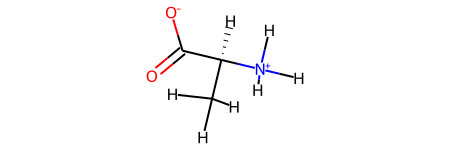

In [60]:
# Imports
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

# Hide tracebacks for simpler errors
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

# Show us alanine
l_alanine = Molecule.from_smiles("C[C@H]([NH3+])C([O-])=O")

def is_zw_l_alanine(mol):
    ret, _ = Molecule.are_isomorphic(mol, l_alanine)
    return ret

l_alanine.visualize()

## From SMILES

SMILES is the classic way to create a `Molecule`. SMILES is a widely-used compact textual representation of arbitrary molecules. This lets us specify an exact molecule, including stereochemistry and bond orders, very easily --- though they may not be the most human-readable format.

The [`Molecule.from_smiles()`](openff.toolkit.topology.Molecule.from_smiles) method is used to create a `Molecule` from a SMILES code.

### Implicit hydrogens SMILES

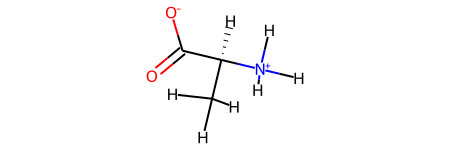

In [61]:
smiles_implicit_h = Molecule.from_smiles("C[C@H]([NH3+])C(=O)[O-]")

assert is_zw_l_alanine(smiles_implicit_h)

smiles_implicit_h.visualize()

### Explicit hydrogens SMILES

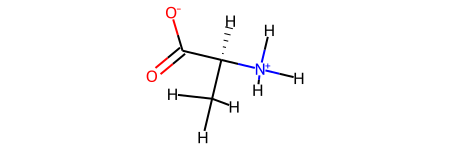

In [62]:
smiles_explicit_h = Molecule.from_smiles(
    "[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]", 
    hydrogens_are_explicit=True
)

assert is_zw_l_alanine(smiles_explicit_h)

smiles_explicit_h.visualize()

### Mapped SMILES

By default, no guarantees are made about the indexing of atoms from a SMILES string. If the indexing is important, a mapped SMILES string may be used. In this case, Hydrogens must be explicit. Note that though mapped SMILES strings must start at index 1, Python lists start at index 0.

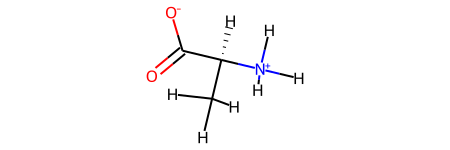

In [120]:
mapped_smiles = Molecule.from_mapped_smiles(
    "[H:10][C:2]([H:7])([H:8])[C@@:4]([H:9])([C:3](=[O:5])[O-:6])[N+:1]([H:11])([H:12])[H:13]"
)

assert is_zw_l_alanine(mapped_smiles)

assert mapped_smiles.atoms[0].atomic_number == 7 # First index is the Nitrogen
assert all([a.atomic_number==1 for a in mapped_smiles.atoms[6:]]) # Final indices are all H

mapped_smiles.visualize()

In [111]:
mapped_smiles.atoms

[Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=7),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1)]

### SMILES without stereochemistry

The Toolkit won't accept an ambiguous SMILES. This SMILES could be L- or D- phenylalanine; rather than guess, the Toolkit throws an error:

In [38]:
smiles_non_isomeric = Molecule.from_smiles(
    "CC([NH3+])C(=O)[O-]"
)

UndefinedStereochemistryError: Unable to make OFFMol from RDMol: Unable to make OFFMol from SMILES: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 1)


We can degrade this error to a warning with the `allow_undefined_stereo` argument. This will not apply an improper dihedral term to the stereocenter and may lead to simulations with unphysical stereoisomerisation.

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 1)



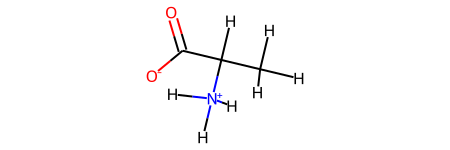

In [63]:
smiles_non_isomeric = Molecule.from_smiles(
    "CC([NH3+])C(=O)[O-]",
    allow_undefined_stereo=True
)

assert not is_zw_l_alanine(smiles_non_isomeric)

smiles_non_isomeric.visualize()

## By hand

You can always construct a `Molecule` by building it up from individual atoms and bonds. Other methods are generally easier, but it's a useful fallback for when you need to write your own constructor for an unsupported source format.

The [`Molecule()`](openff.toolkit.topology.Molecule.__init__) constructor and the [`add_atom()`](openff.toolkit.topology.Molecule.add_atom) and [`add_bond()`](openff.toolkit.topology.Molecule.add_bond) methods are used to construct a `Molecule` by hand.

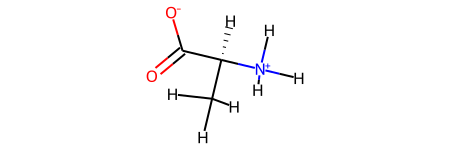

In [64]:
by_hand = Molecule()
by_hand.name = "Zwitterionic l-Alanine"

by_hand.add_atom(
    atomic_number = 8, # Atomic number 8 is Oxygen
    formal_charge = -1, # Formal negative charge
    is_aromatic = False, # Atom is not part of an aromatic system
    stereochemistry = None, # Optional argument; "R" or "S" stereochemistry
    name = "O-" # Optional argument; descriptive name for the atom
)
by_hand.add_atom(6,  0, False, name="C")
by_hand.add_atom(8,  0, False, name="O")
by_hand.add_atom(6,  0, False, stereochemistry="S", name="CA")
by_hand.add_atom(1,  0, False, name="CAH")
by_hand.add_atom(6,  0, False, name="CB")
by_hand.add_atom(1,  0, False, name="HB1")
by_hand.add_atom(1,  0, False, name="HB2")
by_hand.add_atom(1,  0, False, name="HB3")
by_hand.add_atom(7, +1, False, name="N+")
by_hand.add_atom(1,  0, False, name="HN1")
by_hand.add_atom(1,  0, False, name="HN2")
by_hand.add_atom(1,  0, False, name="HN3")


by_hand.add_bond( 
    atom1 = 0, # First (zero-indexed) atom specified above ("O-")  
    atom2 = 1, # Second atom specified above ("C")
    bond_order = 1, # Single bond
    is_aromatic = False, # Bond is not aromatic
    stereochemistry = None, # Optional argument; "E" or "Z" stereochemistry
    fractional_bond_order = None # Optional argument; Wiberg (or similar) bond order
)
by_hand.add_bond( 1,  2, 2, False) # C = O
by_hand.add_bond( 1,  3, 1, False) # C - CA
by_hand.add_bond( 3,  4, 1, False) # CA - CAH
by_hand.add_bond( 3,  5, 1, False) # CA - CB
by_hand.add_bond( 5,  6, 1, False) # CB - HB1
by_hand.add_bond( 5,  7, 1, False) # CB - HB2
by_hand.add_bond( 5,  8, 1, False) # CB - HB3
by_hand.add_bond( 3,  9, 1, False) # CB - N+
by_hand.add_bond( 9, 10, 1, False) # N+ - HN1
by_hand.add_bond( 9, 11, 1, False) # N+ - HN2
by_hand.add_bond( 9, 12, 1, False) # N+ - HN3

assert is_zw_l_alanine(by_hand)

by_hand.visualize()

## From a file

We can construct a `Molecule` from a file or file-like object with the [`from_file()`](openff.toolkit.topology.Molecule.from_file) method. We're a bit constrained in what file formats we can accept, because they need to provide all the information needed to construct the molecular graph; not just coordinates, but also elements, formal charges, bond orders, and stereochemistry.

### From SDF file

We generally recommend the SDF format.

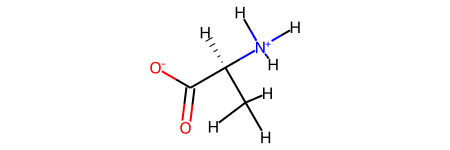

In [122]:
sdf_path = Molecule.from_file("zw_l_alanine.sdf")
assert is_zw_l_alanine(sdf_path)
sdf_path.visualize()

### From SDF file object

`from_file()` can also take a file object, rather than a path. Note that the object must be in binary mode!

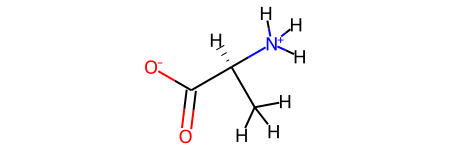

In [79]:
with open("zw_l_alanine.sdf", mode="rb") as file:
    sdf_object = Molecule.from_file(file, file_format="SDF")
    
assert is_zw_l_alanine(sdf_object)
sdf_object.visualize()

### From PDB file

PDB files cannot be supported, even if they have CONECT records, as they do not provide stereoisomeric information or bond orders.

In [84]:
pdb = Molecule.from_file("zw_l_alanine.pdb", "pdb")

NotImplementedError: No toolkits in registry can read file zw_l_alanine.pdb (format C[C@H]([NH3+])C(=O)[O-]). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': [], 'Built-in Toolkit': []}. 

If we provide a SMILES code, a PDB file can be used to populate the `Molecule` object's `conformers` attribute and provide atom ordering, as well as check that the SMILES code matches the PDB file. The warning provided is [spurious](https://github.com/openforcefield/openff-toolkit/issues/1000).

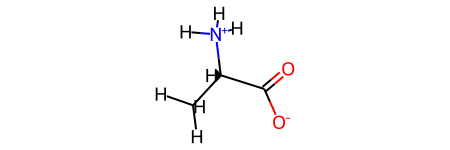

In [129]:
pdb_with_smiles = Molecule.from_pdb_and_smiles(
    "zw_l_alanine.pdb", 
    "C[C@H]([NH3+])C(=O)[O-]"
)  

assert is_zw_l_alanine(pdb_with_smiles)

pdb_with_smiles.visualize()

## From Toolkit objects

The OpenFF Toolkit calls out to other software

# TODO

Several of these methods do not exist in the Molecule class. I have styled them with ~~strikethroughs~~

- [x] “Molecules should have explicit hydrogens, bond orders, formal charges, stereochemistry (defined on GRAPH, not just 3D)”

- [x] Molecule.add_atom and Molecule.add_bond

- [x] from_file

- [x] ~~from_file_obj~~ <!-- This method exists on ToolkitWrapper, but not Molecule -->

- [ ] ~~from_object~~, which really delegates to:

    from_rdkit

    from_openeye

- [x] from_smiles

- [x] from_mapped_smiles

- [ ] from_qcschema

- [ ] offmol.remap (instance method)

- [ ] from_topology

- [ ] from_inchi – “InChI is not intended to be an interchange format” NOTE THAT THIS DOESN’T PRESERVE ATOM ORDER!!

- [ ] from_iupac (requires OpenEye)

- Things that go through Topology, and you actually need to know the GRAPH of the molecule ahead of time (they require a unique_molecules keyword argument with the full identity of the molecules to run). This really just reorders the atoms to be in the other object’s order:

    - [ ] Topology.from_openmm (add’l step mol=topology.reference_molecules[0])

    - [ ] Topology.from_mdtraj (add’l step mol=topology.reference_molecules[0])

- [x] Molecule.from_pdb_and_smiles 

- [ ] Molecule.from_dict() (which underlies from_ bson, json, toml, messagepack, yaml, pickle, etc)